## 1. Import Library



In [13]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")


## 2. Load Data

In [14]:
file_id = "1UJXIe6ioRQDN59Wi_2jtSx0daLRz21bz"
url = f"https://drive.google.com/uc?id={file_id}"
output = "Loan_Default_ModelReady.csv"

gdown.download(url, output, quiet=False)

data = pd.read_csv(output)
print("Dữ liệu sau preprocessing:", data.shape)
print(data.head())


Downloading...
From: https://drive.google.com/uc?id=1UJXIe6ioRQDN59Wi_2jtSx0daLRz21bz
To: /content/Loan_Default_ModelReady.csv
100%|██████████| 25.6M/25.6M [00:00<00:00, 183MB/s]


Dữ liệu sau preprocessing: (148670, 28)
  loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0         cf  Sex Not Available         nopre     type1           p1   
1         cf               Male         nopre     type2           p1   
2         cf               Male           pre     type1           p1   
3         cf               Male         nopre     type1           p4   
4         cf              Joint           pre     type1           p1   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  \
0                l1        nopc                  nob/c       116500   
1                l1        nopc                    b/c       206500   
2                l1        nopc                  nob/c       406500   
3                l1        nopc                  nob/c       456500   
4                l1        nopc                  nob/c       696500   

   rate_of_interest  ...   income credit_type Credit_Score  \
0          0.003371  ...   1740.0     

## 3. EDA


Thông tin tổng quát:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 148670 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              148670 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148670 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   rate_of_interest           148670 non-null  float64
 10  term                       148670 non-null  float64
 11  Neg_ammortization          148670 non-null  object 
 12  interest_only              148670 non-null  object 
 13  lump_su

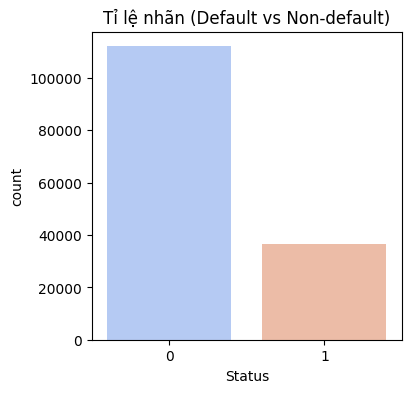


Tỉ lệ nhãn:
 Status
0    0.753555
1    0.246445
Name: proportion, dtype: float64


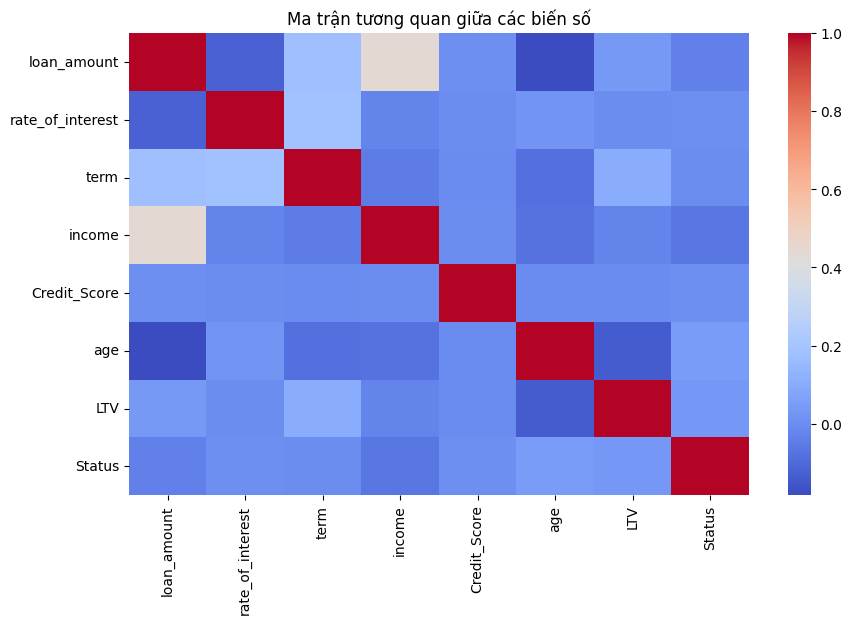

In [15]:
print("\nThông tin tổng quát:")
print(data.info())
print("\nThống kê mô tả:")
print(data.describe().T)

plt.figure(figsize=(4,4))
sns.countplot(x='Status', data=data, palette='coolwarm')
plt.title("Tỉ lệ nhãn (Default vs Non-default)")
plt.show()

target_rate = data['Status'].value_counts(normalize=True)
print("\nTỉ lệ nhãn:\n", target_rate)

plt.figure(figsize=(10,6))
corr = data.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Ma trận tương quan giữa các biến số")
plt.show()


## 4. Split X and Y (Status)

In [16]:
X = data.drop('Status', axis=1)
y = data['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (118936, 27), Test size: (29734, 27)


## 5. Pipeline

In [17]:
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
num_cols = [c for c in X_train.columns if X_train[c].dtype != 'object']

ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('scaler', MinMaxScaler(), num_cols)
    ],
    remainder='drop'
)

model = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', XGBClassifier(
        n_estimators=250,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    ))
])


## 6. Train Model

In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['loan_limit', 'Gender',
                                                   'approv_in_adv', 'loan_type',
                                                   'loan_purpose',
                                                   'Credit_Worthiness',
                                                   'open_credit',
                                                   'business_or_commercial',
                                                   'Neg_ammortization',
                                                   'interest_only',
                                                   'lump_sum_payment',
                                                   'construction_type',
                                                   'occupancy_type'...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=250, n_jobs=-1,
                               num_parallel_tree=None, ...))])

## 7. Metrics and Confusion Matrix


KẾT QUẢ ĐÁNH GIÁ
Accuracy : 1.0
ROC AUC  : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     22406
           1     1.0000    1.0000    1.0000      7328

    accuracy                         1.0000     29734
   macro avg     1.0000    1.0000    1.0000     29734
weighted avg     1.0000    1.0000    1.0000     29734



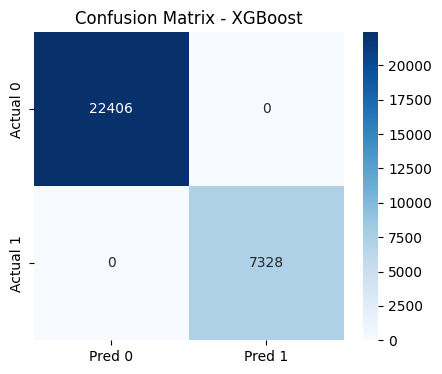

In [19]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = round(accuracy_score(y_test, y_pred), 4)
auc = round(roc_auc_score(y_test, y_prob), 4)
prec = round(precision_score(y_test, y_pred), 4)
rec = round(recall_score(y_test, y_pred), 4)
f1 = round(f1_score(y_test, y_pred), 4)

print("\nKẾT QUẢ ĐÁNH GIÁ")
print(f"Accuracy : {acc}")
print(f"ROC AUC  : {auc}")
print(f"Precision: {prec}")
print(f"Recall   : {rec}")
print(f"F1-score : {f1}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'], yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion Matrix - XGBoost")
plt.show()
